<a href="https://colab.research.google.com/github/WasifAsi/DSGP_GP-19/blob/main/DSGP_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nibabel
!pip PIL
!pip install numpy

ERROR: unknown command "PIL"


In [2]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
from tqdm import tqdm
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import cv2
from skimage.transform import resize

# Data source

- put the raw file path
- prefered directory to store the processed data

In [3]:
raw_data_path = "Oluvil.rar"
target_data_path = "target"

# Connect to the google drive

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Changing the directory
%cd '/content/drive/MyDrive/test/oluvil/updated data'

/content/drive/MyDrive/test/oluvil/updated data


In [ ]:
# # unrar the raw data
# !unrar x -v '{raw_data_path}'

In [12]:
import os

# Path to the .rar file
raw_data_path = "Oluvil.rar"

# Specify the target directory where you want to extract the files
source_dir = os.path.join("target", "dataset")

# Ensure the target directory exists
os.makedirs(source_dir, exist_ok=True)

# Unrar the file into the target directory
!unrar x -v '{raw_data_path}' '{source_dir}/'



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from Oluvil.rar

Creating    target/dataset/Oluvil                                     OK
Creating    target/dataset/Oluvil/EPR                                 OK
Extracting  target/dataset/Oluvil/EPR/sentinel2_void_2019-01-28_Oluvil.png       0%  OK 
Extracting  target/dataset/Oluvil/EPR/sentinel2_void_2019-02-07_Oluvil.png       0%  OK 
Extracting  target/dataset/Oluvil/EPR/sentinel2_void_2019-03-09_Oluvil.png       0%  OK 
Extracting  target/dataset/Oluvil/EPR/sentinel2_void_2019-03-19_Oluvil.png       0%  OK 
Extracting  target/dataset/Oluvil/EPR/sentinel2_void_2019-03-24_Oluvil.png       0%  OK 
Extracting  target/dataset/Oluvil/EPR/sentinel2_void_2019-03-29_Oluvil.png       0%  OK 
Extracting  target/dataset/Oluvil/EPR/sentinel2_void_2019-04-03_Oluvil.png       0%  OK 
Extracting  target/dataset/Oluvil/EPR/sentinel2_void_2019-04-08_

# Partition the data

In [15]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
image_dir = os.path.join(target_data_path, "dataset/Oluvil/satellite")  # Satellite images
mask_dir = os.path.join(target_data_path, "dataset/Oluvil/EPR")  # Binary EPR masks

train_dir = os.path.join(target_data_path, "training")
val_dir = os.path.join(target_data_path, "validation")
test_dir = os.path.join(target_data_path, "testing")

# Print list of files in directories
print("Satellite images:", os.listdir(image_dir))
print("EPR masks:", os.listdir(mask_dir))

# Create directories for training, validation, and testing sets
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(d, "images"), exist_ok=True)
    os.makedirs(os.path.join(d, "masks"), exist_ok=True)

# Get all image filenames (ignoring path)
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# Ensure masks exist for each image (based on base name, with .png extension)
valid_images = [
    f for f in image_filenames
    if os.path.exists(os.path.join(mask_dir, os.path.splitext(f)[0] + '.png'))
]

print(f"Total valid image-mask pairs found: {len(valid_images)}")

# Split dataset (70% train, 15% val, 15% test)
train_files, test_files = train_test_split(valid_images, test_size=0.30, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.50, random_state=42)  # 15% each

# Function to move files
def move_files(file_list, src_img, src_mask, dest):
    for f in file_list:
        mask_filename = os.path.splitext(f)[0] + '.png'  # Construct corresponding mask filename
        shutil.copy(os.path.join(src_img, f), os.path.join(dest, "images", f))
        shutil.copy(os.path.join(src_mask, mask_filename), os.path.join(dest, "masks", mask_filename))

# Move files to respective folders
move_files(train_files, image_dir, mask_dir, train_dir)
move_files(val_files, image_dir, mask_dir, val_dir)
move_files(test_files, image_dir, mask_dir, test_dir)

print("Dataset successfully split into Training, Validation, and Testing sets!")


Satellite images: ['sentinel2_void_2019-01-28_Oluvil.jpg', 'sentinel2_void_2019-02-07_Oluvil.jpg', 'sentinel2_void_2019-03-09_Oluvil.jpg', 'sentinel2_void_2019-03-19_Oluvil.jpg', 'sentinel2_void_2019-03-24_Oluvil.jpg', 'sentinel2_void_2019-03-29_Oluvil.jpg', 'sentinel2_void_2019-04-03_Oluvil.jpg', 'sentinel2_void_2019-04-08_Oluvil.jpg', 'sentinel2_void_2019-04-13_Oluvil.jpg', 'sentinel2_void_2019-04-18_Oluvil.jpg', 'sentinel2_void_2019-05-08_Oluvil.jpg', 'sentinel2_void_2019-05-18_Oluvil.jpg', 'sentinel2_void_2019-05-28_Oluvil.jpg', 'sentinel2_void_2019-06-27_Oluvil.jpg', 'sentinel2_void_2019-07-07_Oluvil.jpg', 'sentinel2_void_2019-08-21_Oluvil.jpg', 'sentinel2_void_2019-09-10_Oluvil.jpg', 'sentinel2_void_2019-10-05_Oluvil.jpg', 'sentinel2_void_2019-12-24_Oluvil.jpg', 'sentinel2_void_2020-03-03_Oluvil.jpg', 'sentinel2_void_2020-03-08_Oluvil.jpg', 'sentinel2_void_2020-03-23_Oluvil.jpg', 'sentinel2_void_2020-03-28_Oluvil.jpg', 'sentinel2_void_2020-04-02_Oluvil.jpg', 'sentinel2_void_2020-

# Visualize raw data

In [43]:
# Plot image and its corresponding segmentation mask
def plot_images(img, mask):
    if img is None or mask is None:
        print("Error: One or both files could not be loaded.")
        return

    print("img shape:", img.shape)
    print("mask shape:", mask.shape)
    print("mask min:", mask.min())
    print("mask max:", mask.max())
    print("mask unique values:", np.unique(mask))

    viz_dict = {"Image": img, "Segmentation Map": mask}

    fig = plt.figure(figsize=(15, 15))

    count = 2
    for i, j in viz_dict.items():
        ax = plt.subplot(1, 3, count)
        plt.imshow(j, cmap='gray')
        plt.title(i)
        plt.axis("on")
        count += 1


def plot_images_by_path(image_path, mask_path):
    # Check if files exist
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return

    if not os.path.exists(mask_path):
        print(f"Error: Mask file not found at {mask_path}")
        return

    img = cv2.imread(image_path)  # Load the image in color (BGR format)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load the mask in grayscale (binary)

    plot_images(img, mask)


def plot_images_after_cleaning(img,mask):

  print("img " , img.shape)
  print("mask ", mask.shape)
  print("mask min ", mask.min())
  print("mask max ", mask.max())
  print("mask unique values ", np.unique(mask))

  viz_dict = {"Image": img[:,:,0], "Segmentation Map": mask}
  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.colorbar()
    plt.title(i)
    plt.axis("on")
    count += 1


img shape: (1741, 1146, 3)
mask shape: (1741, 1146)
mask min: 0
mask max: 255
mask unique values: [  0 255]


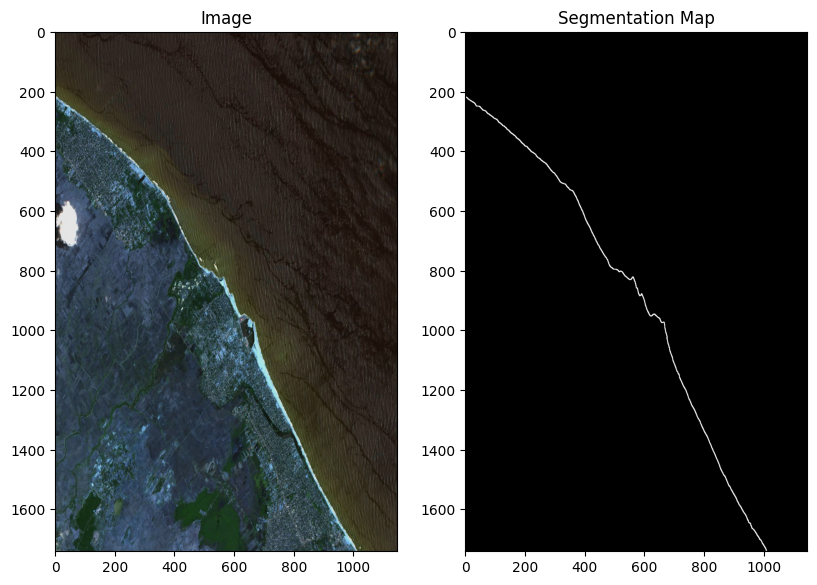

In [19]:
image_path = 'target/training/images/sentinel2_void_2022-10-09_Oluvil.jpg'
mask_path =  'target/training/masks/sentinel2_void_2022-10-09_Oluvil.png'

plot_images_by_path(image_path, mask_path)

# Slect and load the data

In [21]:
# Function to select image and mask files
def select_data(env, datatype_annotation):
    file_input = f'target/{env}/*/*{datatype_annotation}*'
    return sorted(glob.glob(file_input))

# Function to load images and masks
def load_data(image_filenames, mask_filenames):
    images = []
    masks = []

    # Load images
    for file_name in tqdm(image_filenames):
        img = cv2.imread(file_name)  # Read image in color (BGR)
        if img is None:
            print(f"Error: Unable to load {file_name}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)

    # Load masks
    for file_name in tqdm(mask_filenames):
        mask = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if mask is None:
            print(f"Error: Unable to load {file_name}")
            continue
        masks.append(mask)

    return images, masks


## Training

In [25]:
# Select files for training images and masks
training_image_files = select_data('training', '.jpg')
training_mask_files = select_data('training', '.png')

# Load training images and masks
training_images, training_masks = load_data(training_image_files, training_mask_files)

# Print sample information
print(f"\n \nTraining images: {len(training_images)}")
print(f"Training masks: {len(training_masks)}")

100%|██████████| 48/48 [00:01<00:00, 45.24it/s]


 
Training images: 48
Training masks: 48


## Testing

In [26]:
# Select files for training images and masks
testing_image_files = select_data('testing', '.jpg')
testing_mask_files = select_data('testing', '.png')

# Load testing images and masks
testing_images, testing_masks = load_data(testing_image_files, testing_mask_files)

# Print sample information
print(f"testing images: {len(testing_images)}")
print(f"testing masks: {len(testing_masks)}")

100%|██████████| 11/11 [00:00<00:00, 53.73it/s]

testing images: 11
testing masks: 11


## Validation

In [27]:

# Select files for validation images and masks
validation_image_files = select_data('validation', '.jpg')
validation_mask_files = select_data('validation', '.png')

# Load validation images and masks
validation_images, validation_masks = load_data(validation_image_files, validation_mask_files)

# Print sample information
print(f"validation images: {len(validation_images)}")
print(f"validation masks: {len(validation_masks)}")

100%|██████████| 10/10 [00:00<00:00, 52.87it/s]

validation images: 10
validation masks: 10


# Formating

- resizing the image

In [57]:
from skimage.transform import resize

def resize_images(images_raw, masks_raw):
  images = []
  masks = []

  for img, msk in zip(images_raw, masks_raw):
      # Resize to 200x200
      bottle_img = resize(img, (240, 240))
      # bottle_mask = resize(msk, (240, 240))
      bottle_mask = cv2.resize(msk, (240, 240), interpolation=cv2.INTER_NEAREST) #using interpolation to make sure we don't losse information while averaging the class values while resizing

      images.append(bottle_img)
      masks.append(bottle_mask)

  return images, masks;

In [58]:
# Trainning data resize
training_images, training_masks = resize_images(training_images, training_masks)

# Testing data resize
testing_images, testing_masks = resize_images(testing_images, testing_masks)

# Validation data resize
validation_images, validation_masks = resize_images(validation_images, validation_masks)

img  (1000, 1000, 3)
mask  (1000, 1000)
mask min  0
mask max  255
mask unique values  [  0 255]


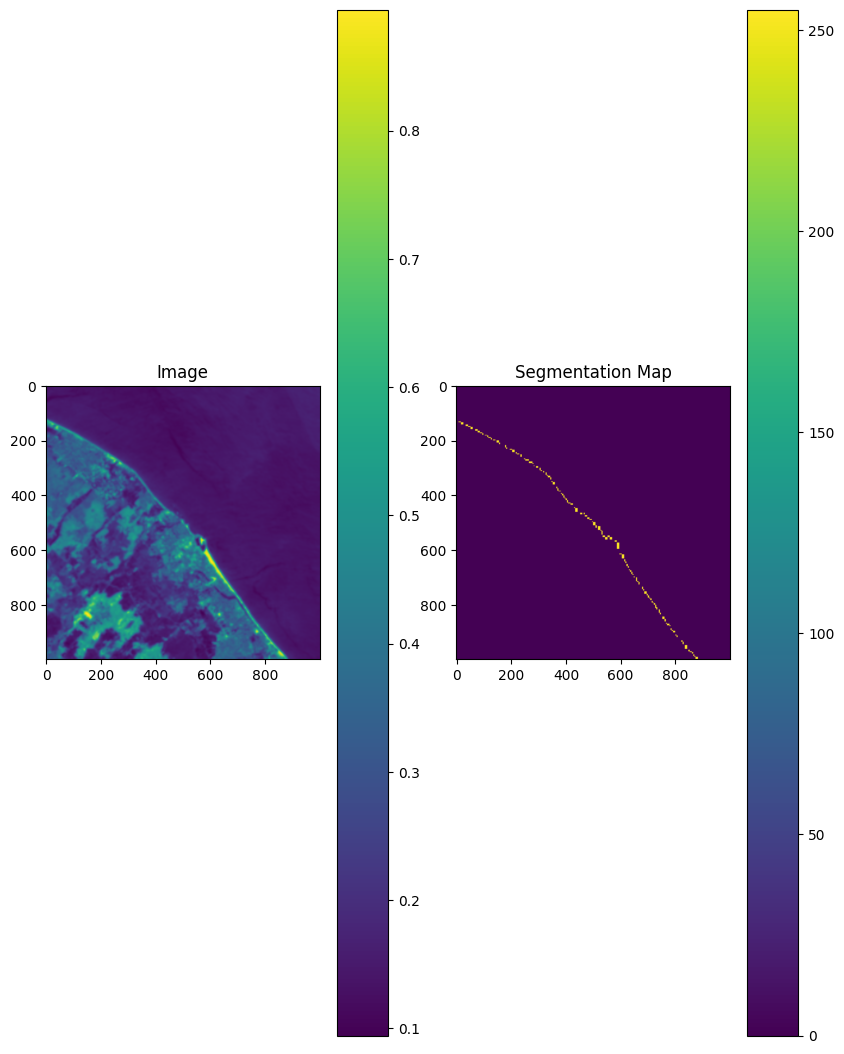

In [59]:
plot_images_after_cleaning(validation_images[0], validation_masks[0])

In [33]:
!mkdir 'target/training/numpy'
!mkdir 'target/testing/numpy'
!mkdir 'target/validation/numpy'

In [34]:
np.save('target/training/numpy/images.npy', training_images)
np.save('target/training/numpy/masks.npy', training_masks)

In [35]:
np.save('target/testing/numpy/images.npy', testing_images)
np.save('target/testing/numpy/masks.npy', testing_masks)

In [36]:
np.save('target/validation/numpy/images.npy', validation_images)
np.save('target/validation/numpy/masks.npy', validation_masks)

img shape: (348, 230, 3)
mask shape: (348, 230)
mask min: 0
mask max: 255
mask unique values: [  0 255]


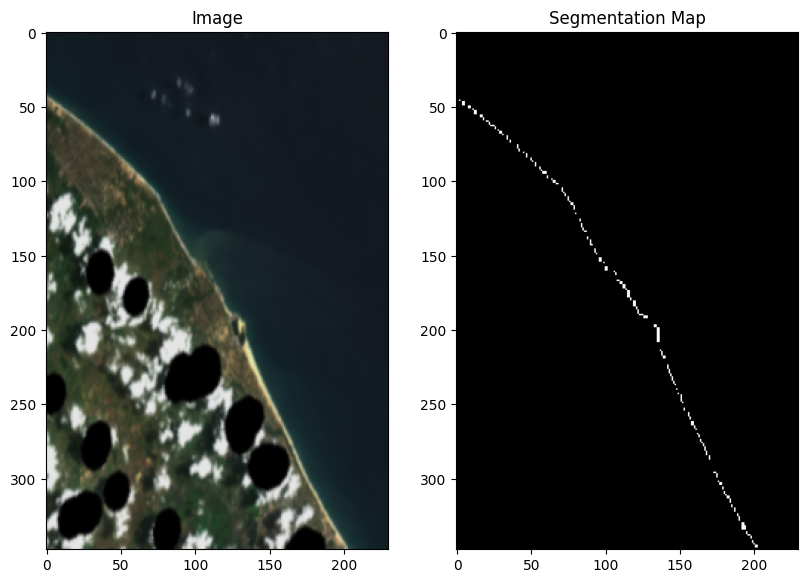

In [56]:
plot_images(training_images[0],training_masks[0])